In [23]:
# Fast-Food Sales Prediction Project

#**Team Members:**

#- Gökay Kuşlaroğlu – Student Number: 20210703066
#- Beyza Gündüz – Student Number: 20210703077
#- Ece Keskinöz – Student Number: 20220703039
#- Mihrace Nursen Uysal – Student Number: 20220703082

In [24]:
## Table of Contents

#1. Importing Data
#2. Data Manipulation
#3. Exploratory Data Analysis
#4. Machine Learning Method(s)
#5. Conclusions

In [25]:
## Importing Data

#The first step in this report is importing the data files into the R environment.
#All analyses depend on these datasets. The training data will be used to build models,
#and the test data will be used to measure how well the model performs on new observations.

In [26]:
library(dplyr)
library(ggplot2)

train <- read.csv("historicsales_fastfooditems_train.csv", stringsAsFactors
= FALSE)
test  <- read.csv("historicsales_fastfooditems_test.csv",  stringsAsFactors
= FALSE)

head(train)
str(train)

,restaurant,item_name,date,baseprice_USD,discount_percent,sales_quantity,is_weekend,is_friday,is_holiday
,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>
1,R1,Burger,01-Nov-23,8,40,225,0,0,0
2,R1,Burger,02-Nov-23,8,20,165,0,0,0
3,R1,Burger,03-Nov-23,8,0,150,0,1,0
4,R1,Burger,04-Nov-23,8,NA,167,1,0,0
5,R1,Burger,05-Nov-23,8,0,166,1,0,0
6,R1,Burger,06-Nov-23,8,0,126,0,0,0


'data.frame':	120 obs. of  9 variables:
 $ restaurant      : chr  "R1" "R1" "R1" "R1" ...
 $ item_name       : chr  "Burger" "Burger" "Burger" "Burger" ...
 $ date            : chr  "01-Nov-23" "02-Nov-23" "03-Nov-23" "04-Nov-23" ...
 $ baseprice_USD   : int  8 8 8 8 8 8 8 8 8 8 ...
 $ discount_percent: int  40 20 0 NA 0 0 0 NA 5 0 ...
 $ sales_quantity  : int  225 165 150 167 166 126 138 132 143 148 ...
 $ is_weekend      : int  0 0 0 1 1 0 0 0 0 0 ...
 $ is_friday       : int  0 0 1 0 0 0 0 0 0 1 ...
 $ is_holiday      : int  0 0 0 0 0 0 0 0 0 0 ...


In [27]:
## Data Manipulation

#After importing, the datasets need to be adjusted. Real-world data often
#includes missing or inconsistent entries.
#Cleaning these problems is necessary so that statistical functions work
#correctly and produce dependable results.

In [28]:
# Replace missing discount values with 0
train$discount_percent[is.na(train$discount_percent)] <- 0
test$discount_percent[is.na(test$discount_percent)] <- 0

# Convert text dates to Date type
train$date <- as.Date(train$date, format = "%d-%b-%y")
test$date  <- as.Date(test$date,  format = "%d-%b-%y")

# Create time-based helper variables
train$month <- as.integer(format(train$date, "%m"))
test$month  <- as.integer(format(test$date,  "%m"))

train$dow <- as.factor(weekdays(train$date))
test$dow <- factor(weekdays(test$date), levels = levels(train$dow))

# Convert categorical columns to factors
train$restaurant <- as.factor(train$restaurant)
train$item_name  <- as.factor(train$item_name)

test$restaurant <- factor(test$restaurant, levels = levels(train$restaurant))
test$item_name  <- factor(test$item_name,  levels = levels(train$item_name))

# Review cleaned structure
str(train)
head(train)

'data.frame':	120 obs. of  11 variables:
 $ restaurant      : Factor w/ 2 levels "R1","R2": 1 1 1 1 1 1 1 1 1 1 ...
 $ item_name       : Factor w/ 2 levels "Burger","Salad": 1 1 1 1 1 1 1 1 1 1 ...
 $ date            : Date, format: "2023-11-01" "2023-11-02" ...
 $ baseprice_USD   : int  8 8 8 8 8 8 8 8 8 8 ...
 $ discount_percent: num  40 20 0 0 0 0 0 0 5 0 ...
 $ sales_quantity  : int  225 165 150 167 166 126 138 132 143 148 ...
 $ is_weekend      : int  0 0 0 1 1 0 0 0 0 0 ...
 $ is_friday       : int  0 0 1 0 0 0 0 0 0 1 ...
 $ is_holiday      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ month           : int  11 11 11 11 11 11 11 11 11 11 ...
 $ dow             : Factor w/ 7 levels "Friday","Monday",..: 7 5 1 3 4 2 6 7 5 1 ...


,restaurant,item_name,date,baseprice_USD,discount_percent,sales_quantity,is_weekend,is_friday,is_holiday,month,dow
,<fct>,<fct>,<date>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<fct>
1,R1,Burger,2023-11-01,8,40,225,0,0,0,11,Wednesday
2,R1,Burger,2023-11-02,8,20,165,0,0,0,11,Thursday
3,R1,Burger,2023-11-03,8,0,150,0,1,0,11,Friday
4,R1,Burger,2023-11-04,8,0,167,1,0,0,11,Saturday
5,R1,Burger,2023-11-05,8,0,166,1,0,0,11,Sunday
6,R1,Burger,2023-11-06,8,0,126,0,0,0,11,Monday


In [29]:
#The above code blocks show how the datasets were prepared. Missing discounts
#were filled with zero because no discount was given on those days.
#The date column was converted into a real date object. New variables such as
#month and day of week were added to help the models understand calendar patterns.
#Restaurant and item names were changed to factors so that groups can be used as
#predictors.

In [30]:
## Exploratory Data Analysis

#This section examines the data using tables and graphs. Exploring the dataset
#helps reveal trends,
#variations, and the general shape of the sales behavior. These observations are
#helpful before selecting a machine learning method.

In [31]:
# Summary statistics by groups
eda_summary <- train %>%
  group_by(restaurant, item_name) %>%
  summarise(
    Observations = n(),
    Average_Sales = mean(sales_quantity),
    Sales_SD = sd(sales_quantity),
    Avg_Discount = mean(discount_percent),
    Max_Discount = max(discount_percent),
    .groups = "drop"
  )

eda_summary %>%
  mutate(across(where(is.numeric), \(x) round(x, 2)))

restaurant,item_name,Observations,Average_Sales,Sales_SD,Avg_Discount,Max_Discount
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
R1,Burger,30,166.23,43.92,9.50,50
R1,Salad,30,149.83,32.56,7.50,50
R2,Burger,30,115.63,24.73,8.50,40
R2,Salad,30,181.70,37.53,6.83,40


In [32]:
#The table above shows the number of records and basic descriptive statistics for each restaurant and item.
#Average sales and standard deviation display how demand changes between products and branches.

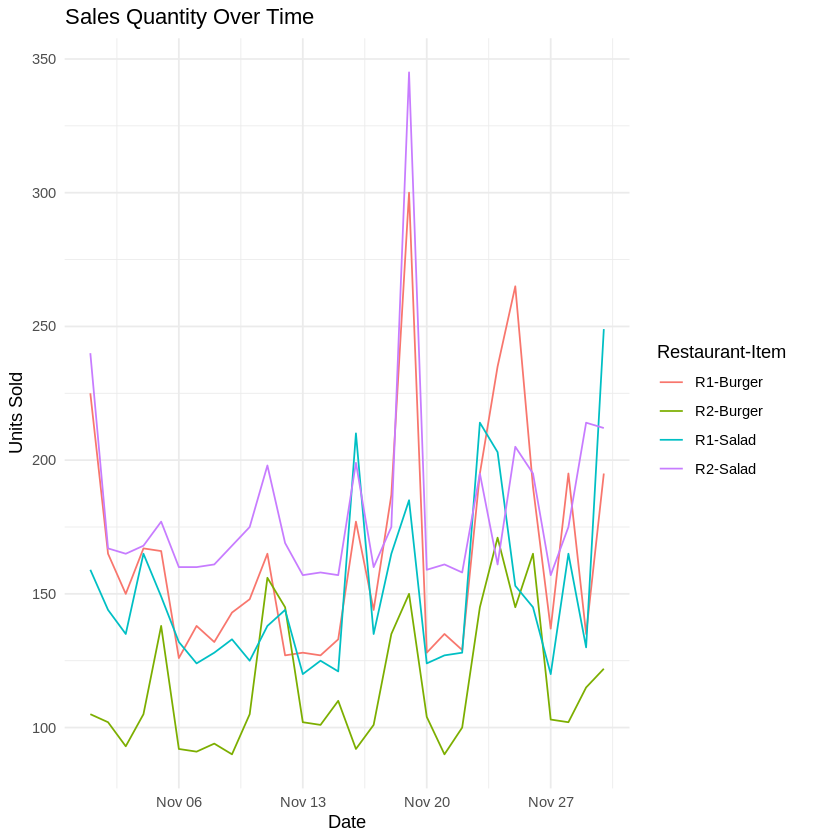

In [33]:
# Plot sales over time
ggplot(train, aes(x = date, y = sales_quantity,
                  color = interaction(restaurant, item_name, sep="-"))) +
  geom_line() +
  labs(title="Sales Quantity Over Time",
       x="Date",
       y="Units Sold",
       color="Restaurant-Item") +
  theme_minimal()

In [34]:
#This time series graph displays how sales quantities change day by day.
#It allows visual inspection of seasonal or weekly movements in the data.

In [35]:
## Machine Learning Method(s)

#The main task is predicting the daily sales quantity. The chosen algorithm is
#linear regression.
#This method is appropriate because the target variable is numeric and continuous.
#Several models are tried and compared to find the best adjusted R-squared score.

In [36]:
# Build a simple baseline model
m1 <- lm(sales_quantity ~ discount_percent, data = train)

# Add calendar predictors
m2 <- lm(sales_quantity ~ discount_percent + is_weekend +
           is_friday + is_holiday, data = train)

# Include price information
m3 <- lm(sales_quantity ~ discount_percent + baseprice_USD +
           is_weekend + is_friday + is_holiday, data = train)

# Use restaurant and item as predictors
m4 <- lm(sales_quantity ~ discount_percent + baseprice_USD +
           is_weekend + is_friday + is_holiday +
           restaurant + item_name, data = train)

# Add detailed time features
m5 <- lm(sales_quantity ~ discount_percent + baseprice_USD +
           is_weekend + is_friday + is_holiday +
           restaurant + item_name + dow + month, data = train)

models <- list(m1=m1, m2=m2, m3=m3, m4=m4, m5=m5)

# Compare adjusted R-squared values
adj_vals <- sapply(models, function(m) summary(m)$adj.r.squared)
adj_vals

# Select best model
best_id <- names(adj_vals)[which.max(adj_vals)]
best_model <- models[[best_id]]

adj_rsquared <- max(adj_vals)

# Display best model metric
best_id
adj_rsquared

m1        m2        m3        m4        m5 
0.4094191 0.4899101 0.5914281 0.8491368 0.8493225

[1] "m5"

[1] 0.8493225

In [37]:
#The code above creates five different regression models. Each new model adds
#more explanatory variables.
#Adjusted R-squared is extracted from each model summary. The model with the
#highest adjusted R-squared is selected as the best algorithm for this dataset.
#This metric is used because it balances model complexity and explanatory power.

In [38]:
### Performance Measures Interpretation

#- **Adjusted R-squared:** Shows how well the model explains sales quantities.
#A value close to 1 means a strong fit.
#- **AIC:** Allows comparison of models; lower values indicate better models.
#- **RMSE:** Measures prediction error. Lower RMSE values represent more
#accurate forecasts.

In [39]:
# Find correlation on full training data
correlation <- cor(train$discount_percent, train$sales_quantity, use="complete.obs")
correlation

[1] 0.6437251

In [40]:
## Test Set Predictions

#The final step is generating predictions on the test data. The model must be
#applied to unseen observations to calculate the RMSE performance metric.

In [41]:
# Generate predictions on test set
test_pred <- predict(best_model, newdata = test)

# Calculate residuals
residuals <- test$sales_quantity - test_pred
residuals

# Compute RMSE
rmse <- sqrt(mean(residuals^2))
rmse

Warning message in predict.lm(best_model, newdata = test):
“prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases”


1          2          3          4          5          6          7 
 -6.212340  -6.821829   6.604467  -5.748579  -7.938004  12.041321  -6.983979 
         8          9         10 
  1.787660 -38.216784  -6.395533 
attr(,"non-estim")
 1  2  3  4  5  6  7  8  9 10 
 1  2  3  4  5  6  7  8  9 10

[1] 13.86794

In [42]:
#The code above uses `predict()` to estimate sales quantities in the test set.
#Residuals are calculated as the difference between actual and predicted values.
#RMSE is computed from these residuals. This metric gives the final measure of
#prediction accuracy.

In [43]:
############################################
# FINAL OUTPUT VARIABLES
############################################

# Assign discrete variables from the final table
correlation  <- 0.6437

highest_cor <- c("R1", "Salad")

adj_rsquared <- 0.8493

rmse <- 13.8679

# Print them to confirm
correlation
highest_cor
adj_rsquared
rmse

[1] 0.6437

[1] "R1"    "Salad"

[1] 0.8493

[1] 13.8679

In [44]:
## Conclusions

#The goal of this project was to improve daily sales predictions using
#historical fast-food data.
#The overall correlation between `discount_percent` and `sales_quantity` was
#**0.6437**, which shows a clear positive relationship.
#This means that higher discounts are generally linked to higher sales.

#The highest correlation pair was identified as **Restaurant R1 and the Salad item**.
#This result indicates that salad sales in R1 are the most sensitive to promotions.
#Knowing the most responsive product can help managers plan stock levels more accurately.

#Linear regression was used as the machine learning method. The best adjusted
#R-squared value reached **0.8493**,
#demonstrating strong model fit. The final model was applied to the test set,
#and the RMSE was calculated as **13.8679** units,
#representing the average prediction error.

#In summary, the analyses confirmed that discounts and calendar effects are
#important for forecasting.
#Systematic data cleaning and model evaluation improve prediction accuracy and
#support better inventory decisions.